In [2]:
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_rows', 100)

%load_ext autoreload

from charts import plot_line, plot_bar, plot_peak, print_charts_country
from features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

In [3]:
date_apple = '2020-05-09'

In [4]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type', 'alternative_name'])]
    
    df_region['dates'] = pd.to_datetime(df_region.index)
    df_region.set_index('dates', inplace=True)
    df_region = df_region.astype('float')
    
    return df_region

In [5]:
def add_forecast_prophet(df_in, column, window=60, ):
    from fbprophet import Prophet
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame({ 'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day',inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast ], axis=1)
    df_result[f'{column}_pred'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]
    
    return df_result


In [6]:
def prepare_df_country(df_confirmed, df_dead, country, country_code, date_cutoff='2020-03-15'):
    df = df_confirmed.loc[df_confirmed.index >= date_cutoff, [country]]
    df.columns = ['confirmed']
    df = add_variables_covid(df, population=population[country_code])

    df_d = df_dead.loc[df_dead.index >= date_cutoff, [country]]
    df_d.columns = ['dead']
    df = df.merge(df_d, left_index=True, right_index=True)
    df = add_variables_covid(df, column='dead', population=population[country_code])
    
    return df

# World Bank Data

In [279]:
import world_bank_data as wb

countries = wb.get_countries()

# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)

# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country_wb'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population['country_wb'] = df_population['country_wb'].astype('string')
df_population['iso_code'] = df_population.index
df_population.head(1)

,region,country_wb,population,iso_code
id,,,,
ABW,Latin America & Caribbean,Aruba,105845.0,ABW


In [486]:
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")

dfapple = pd.read_csv(f"../AppleMobilty/applemobilitytrends-{date_apple}.csv")

dfcovid_conf = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_uid = pd.read_csv("../covid-19-JHU CSSE/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

df_uid = df_uid.loc[df_uid['Province_State'].isnull() == True, ['iso3', 'Country_Region']]
df_uid.columns = ['iso_code', 'country']

dfcovid_conf.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_conf.columns[4:])
dfcovid_dead.columns = ['state', 'country', 'lat', 'lng'] + list(dfcovid_dead.columns[4:])
dfcovid_conf = dfcovid_conf.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))
dfcovid_dead = dfcovid_dead.merge(df_uid, how='outer', on='country', suffixes=('_x', '_y'))

df_rki_germany = pd.read_csv("data-RKI-parse/RKI-reports.csv")
df_rki_germany.drop('data', axis=1, inplace=True)

df_population_de = pd.read_csv('german_lander_population.csv')

In [487]:
# dfcovid_conf.loc[dfcovid_conf['country'] == 'China',:].reset_index()

In [488]:
dfcovid_conf = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :]
dfcovid_dead = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :]

In [489]:
df_population = df_population.merge(dfcovid_conf.loc[:, ['iso_code', 'country']].drop_duplicates(), how='inner',  on='iso_code',  suffixes=('_x', '_y'), left_index=False, right_index=False,)

In [490]:
df_population

,region,country_wb,population,iso_code,country_x,country_y
0,South Asia,Afghanistan,37172386.0,AFG,Afghanistan,Afghanistan
1,Sub-Saharan Africa,Angola,30809762.0,AGO,Angola,Angola
2,Europe & Central Asia,Albania,2866376.0,ALB,Albania,Albania
3,Europe & Central Asia,Andorra,77006.0,AND,Andorra,Andorra
4,Middle East & North Africa,United Arab Emirates,9630959.0,ARE,United Arab Emirates,United Arab Emirates
...,...,...,...,...,...,...
174,East Asia & Pacific,Vietnam,95540395.0,VNM,Vietnam,Vietnam
175,Middle East & North Africa,"Yemen, Rep.",28498687.0,YEM,Yemen,Yemen
176,Sub-Saharan Africa,South Africa,57779622.0,ZAF,South Africa,South Africa
177,Sub-Saharan Africa,Zambia,17351822.0,ZMB,Zambia,Zambia


## Join Population data

In [491]:
df_rki_germany = df_rki_germany.merge(df_population_de, 
                                            how='inner',
                                            left_on='land',
                                            right_on='name',
                                            left_index=False,
                                            right_index=False,
                                            suffixes=('_x', '_y'),)

### Add index to RKI data

In [492]:
df_rki_germany['date'] = df_rki_germany['date'].astype('datetime64[ns]')
df_rki_germany = df_rki_germany.sort_values('date', ascending=True)
df_rki_germany.set_index('date', inplace=True)

## Calculate all German States

In [493]:
lands_calculated = dict()
for land in df_rki_germany.land.unique():
    df = df_rki_germany.loc[df_rki_germany.land == land, :].copy()
    pop = int(df.loc[df.land==land, 'population'][0])
    df = add_variables_covid(df, 'confirmed', population=pop)
    df = add_variables_covid(df, 'dead', population=pop)
    lands_calculated[land] = df

In [496]:
pd.concat([df for df in lands_calculated.values()]).to_csv('data_rki_prepared.csv')

### Transpose Confirmed Cases

In [257]:
dfcovid_conf_t = dfcovid_conf.loc[dfcovid_conf['state'].isnull() == True, :].T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['country', :].astype(str)
dfcovid_conf_t.drop(['country'], axis=0, inplace=True)
df_country_coords = dfcovid_conf_t.loc[['lat', 'lng'], :]
dfcovid_conf_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)
dfcovid_conf_t = dfcovid_conf_t.astype(float)

### Transpose Dead Cases

In [258]:
dfcovid_dead_t = dfcovid_dead.loc[dfcovid_dead['state'].isnull() == True, :].T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['country', :].astype(str)
dfcovid_dead_t.drop(['country'], axis=0, inplace=True)


dfcovid_dead_t.drop(['lat', 'lng', 'state', 'iso_code'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)
dfcovid_dead_t = dfcovid_dead_t.astype(float)


In [ ]:
# import inspect
# source_DF = inspect.getsource(add_weekday_weekend)
# print(source_DF)

# Apple Mobility DF

## Transpose Mobility and Filter Region Create lagged and % variables

In [20]:
dfapple_region = apple_filter_region(dfapple, "Hamburg").copy()
dfapple_region = add_variables_apple(dfapple_region)

In [495]:
print("Mobility max date:", max(dfapple_region.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))
print("RKI max date", max(df_rki_germany.index))

Mobility max date: 2020-05-09 00:00:00
Covi world max date 2020-05-10 00:00:00
Covi world max date 2020-05-10 00:00:00
RKI max date 2020-05-11 00:00:00


In [22]:
# plot_lines_plotly(dfapple_region.loc['2020-03-15':,['driving','transit','walking']],
#     title='Hamburg Mobility',
#     show_doubling=False,
#     doubling_days=7,
#     showlegend=True,)

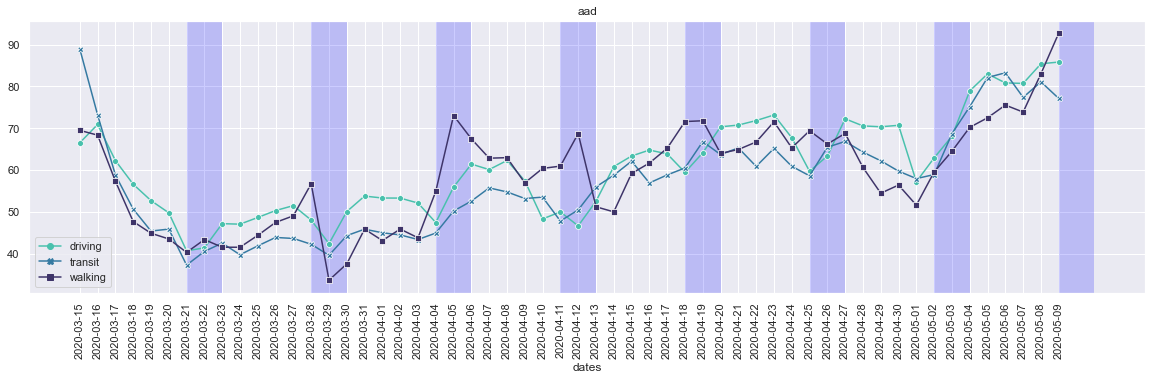

In [23]:
plot_line(dfapple_region, columns=['driving','transit','walking'], date_cutoff='2020-03-15', title='aad')

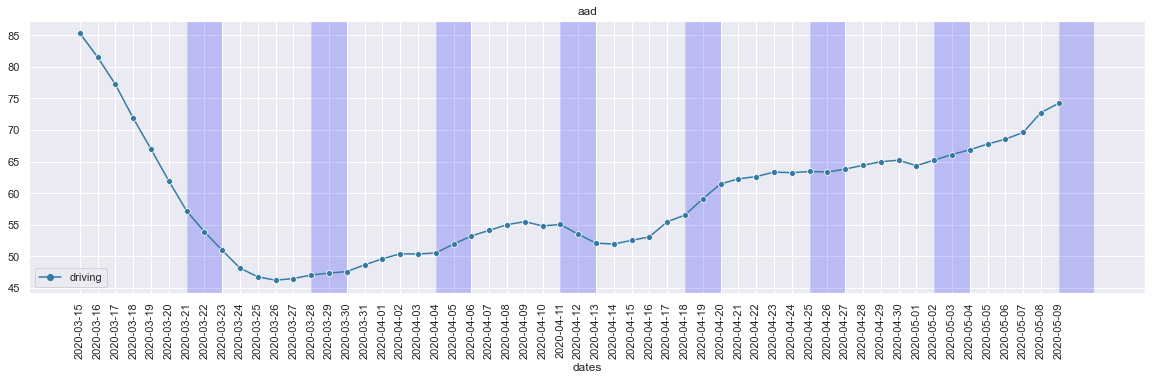

In [24]:
ad_apple_bremen = add_variables_apple(apple_filter_region(dfapple, "The Free Hanseatic City of Bremen"))
plot_line(ad_apple_bremen.rolling(7).mean(), columns=['driving'], date_cutoff='2020-03-15', title='aad')

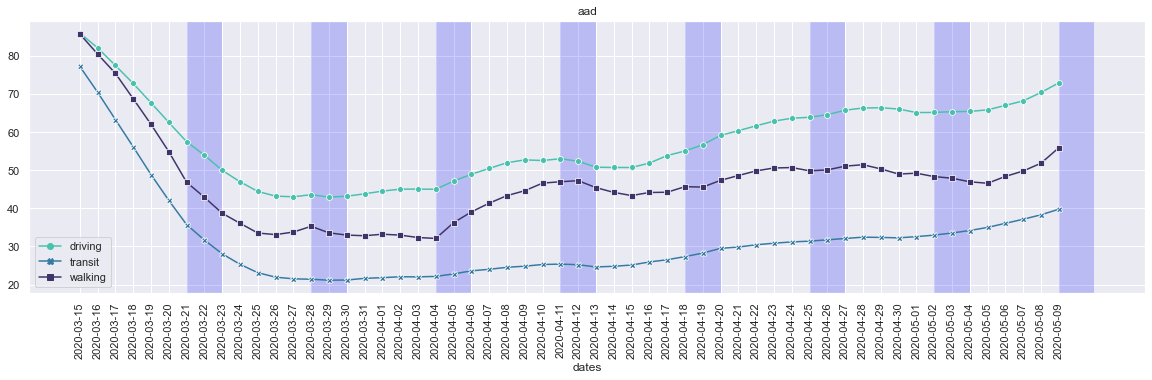

In [25]:
ad_apple_berlin = add_variables_apple(apple_filter_region(dfapple, "Berlin"))
plot_line(ad_apple_berlin.rolling(7).mean(), columns=['driving','transit','walking'], date_cutoff='2020-03-15', title='aad')

In [26]:
# plot_line(dfapple_region, columns=['driving','transit','walking'], resample='W-MON', date_cutoff='2020-03-15')

# Robert Koch Institute DF

----

# Explore Plots

# Hamburg

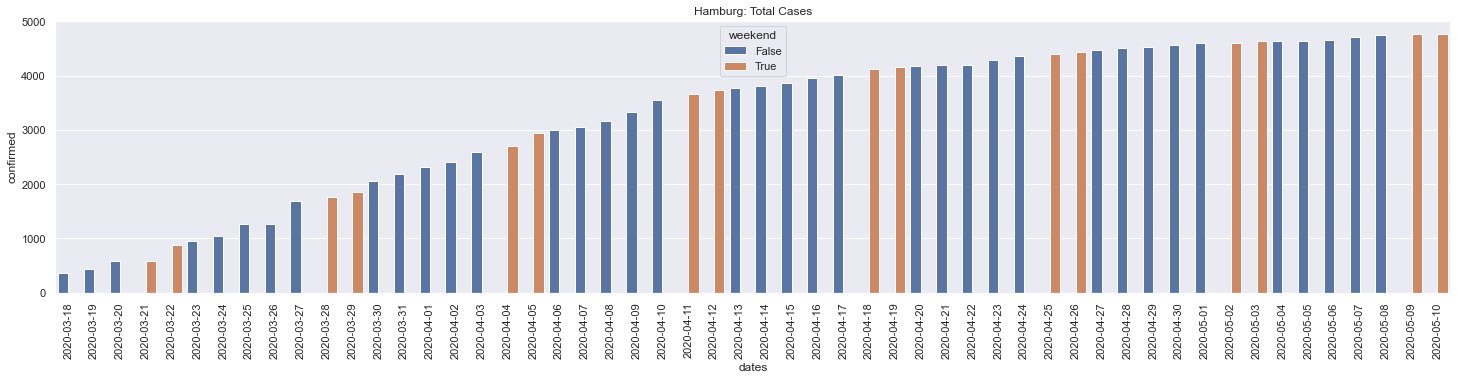

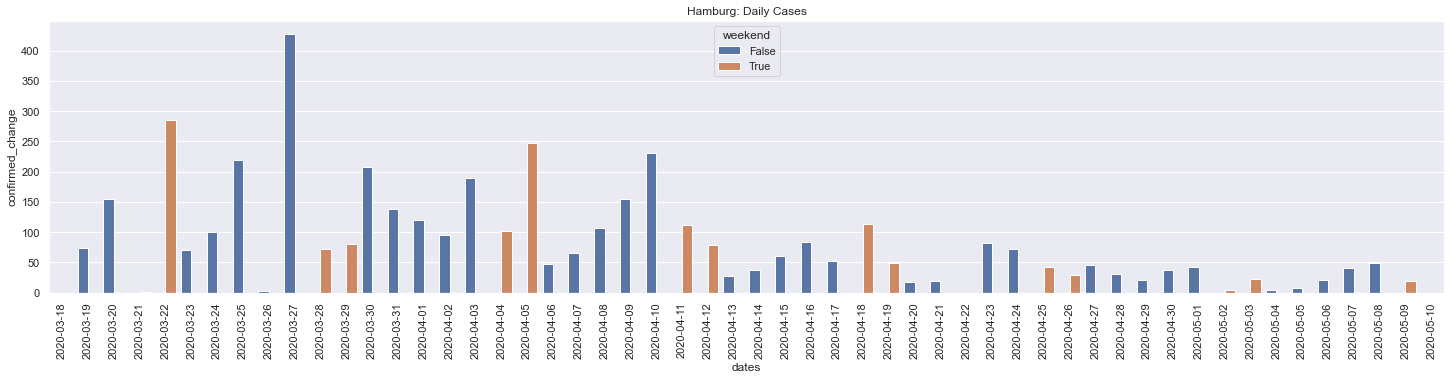

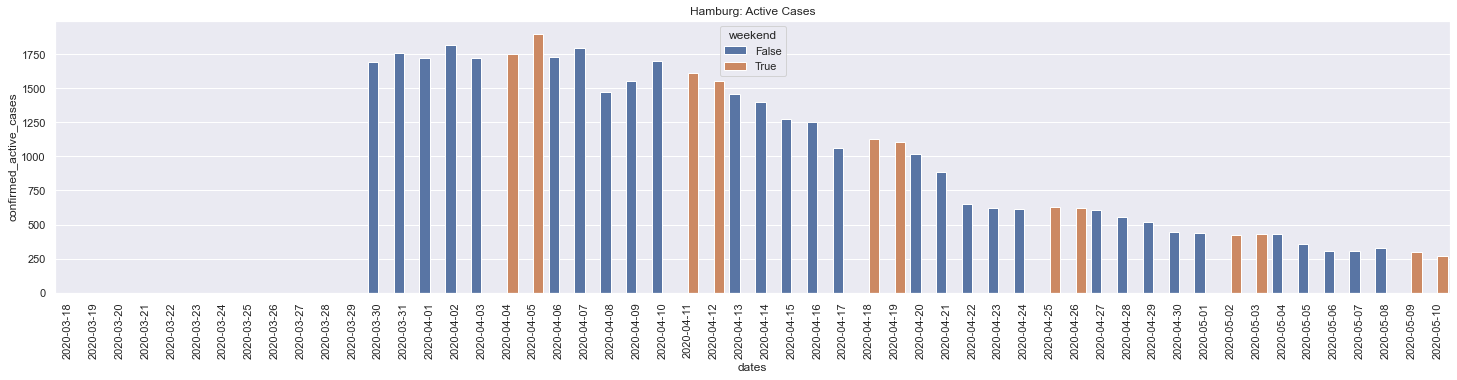

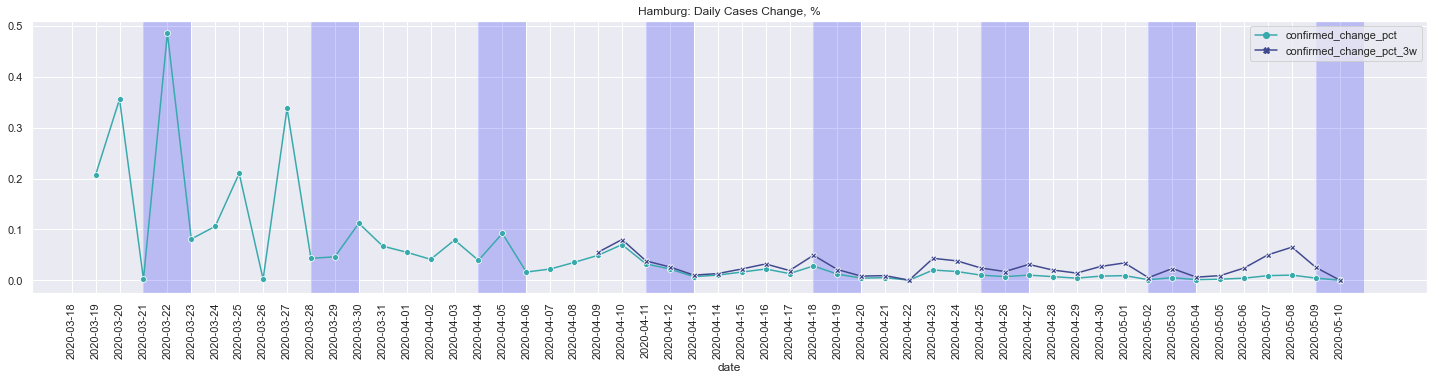

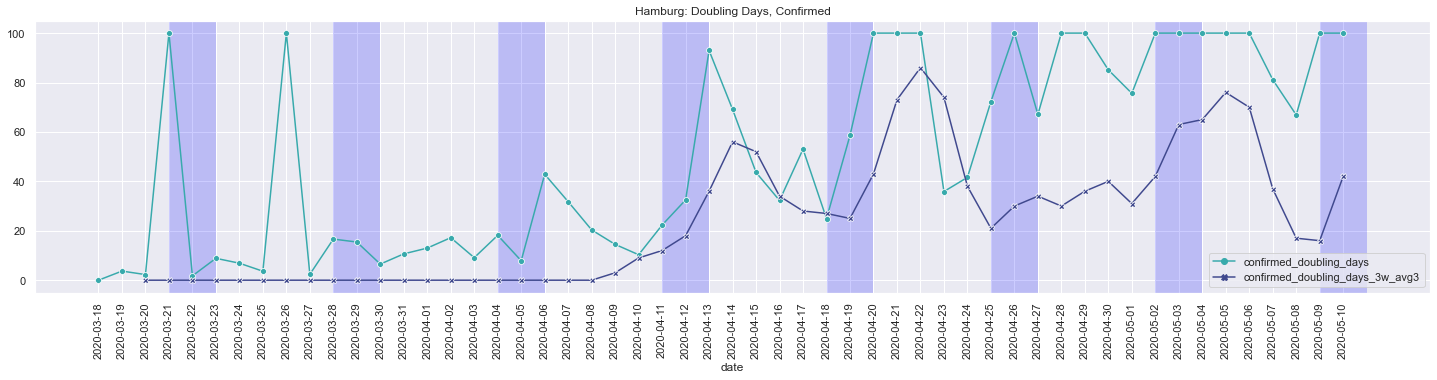

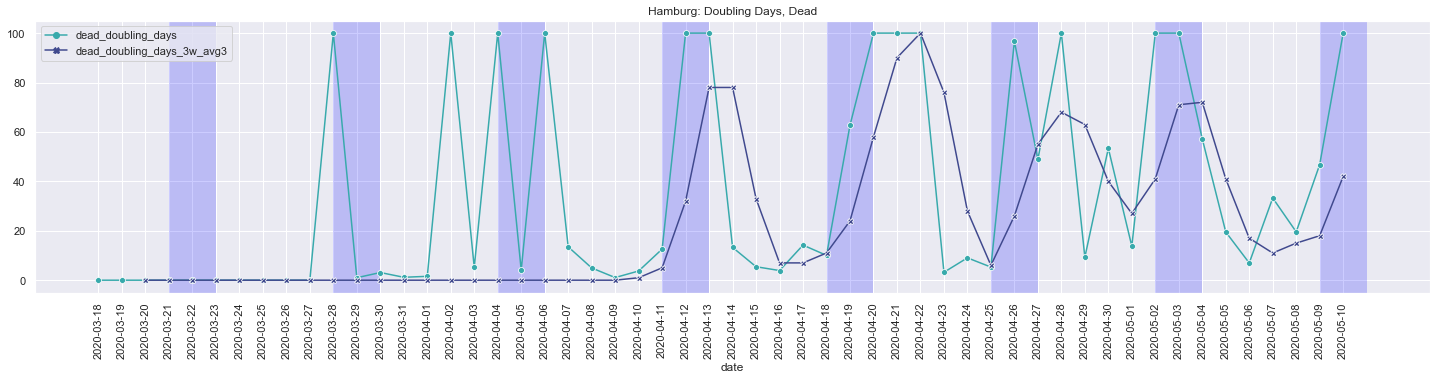

In [28]:
land = 'Hamburg'
print_charts_country(lands_calculated[land], land, date_cutoff='2020-03-15', figsize=(25, 5))

In [30]:
# df = add_forecast_prophet(df_hamburg, 'confirmed_peak', 30)
# plot_peak(df, columns=['confirmed_peak', 'confirmed_peak_pred'], title = 'Hamburg: Peak', date_cutoff='2020-04-15')

# Bremen

In [31]:
# land = 'Bremen'
# print_charts_country(lands_calculated[land], land, date_cutoff='2020-03-15', figsize=(25, 5))

# Berlin

In [32]:
# df = add_forecast_prophet(df_berlin, 'confirmed_peak', 30)
# plot_peak(df, columns=['confirmed_peak', 'confirmed_peak_pred'], title = 'Berlin: Peak', date_cutoff='2020-04-15')

In [33]:
# land = 'Berlin'
# print_charts_country(lands_calculated[land], land, date_cutoff='2020-03-15', figsize=(25, 5))

# Russia

In [34]:
df_russia = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Russia', country_code='RUS', date_cutoff='2020-03-15')

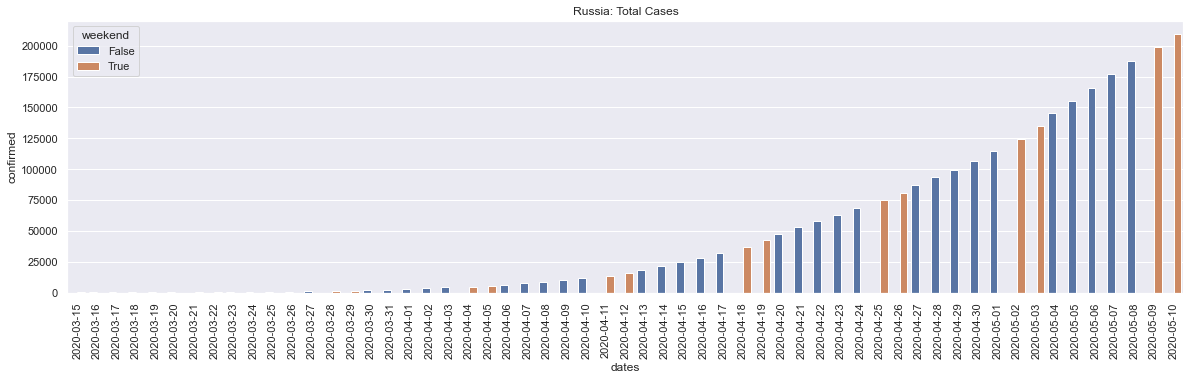

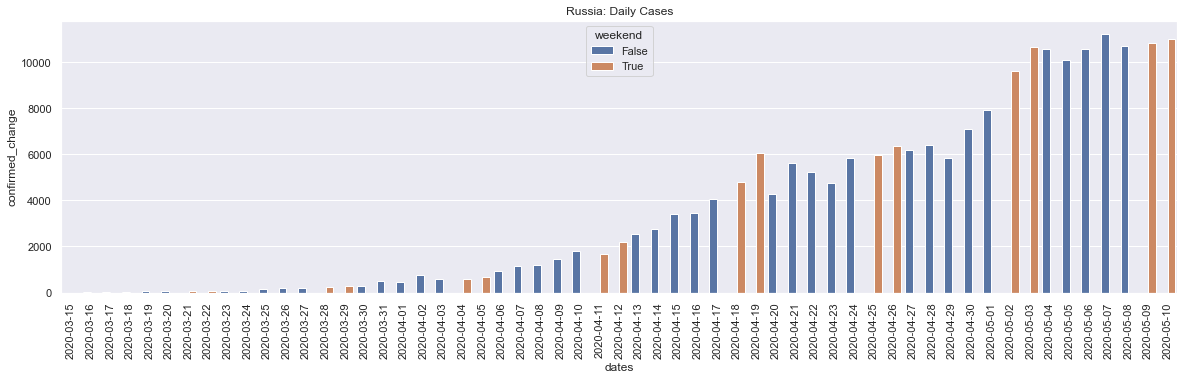

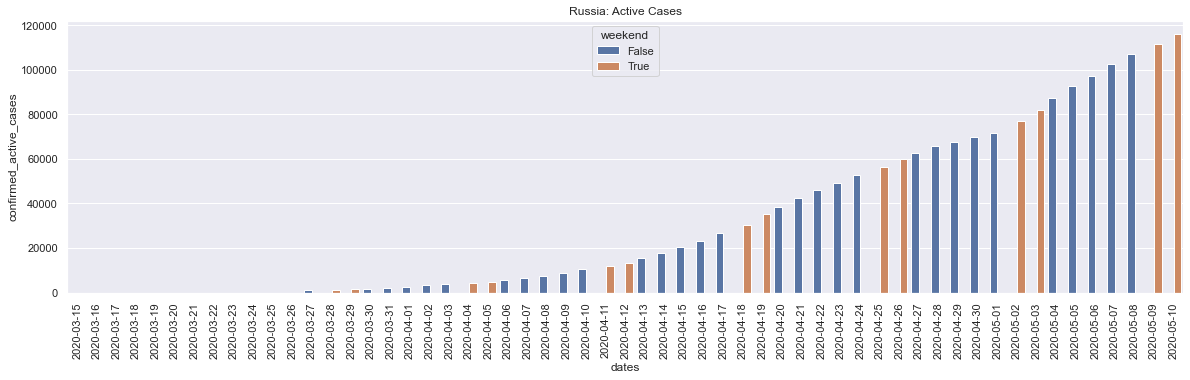

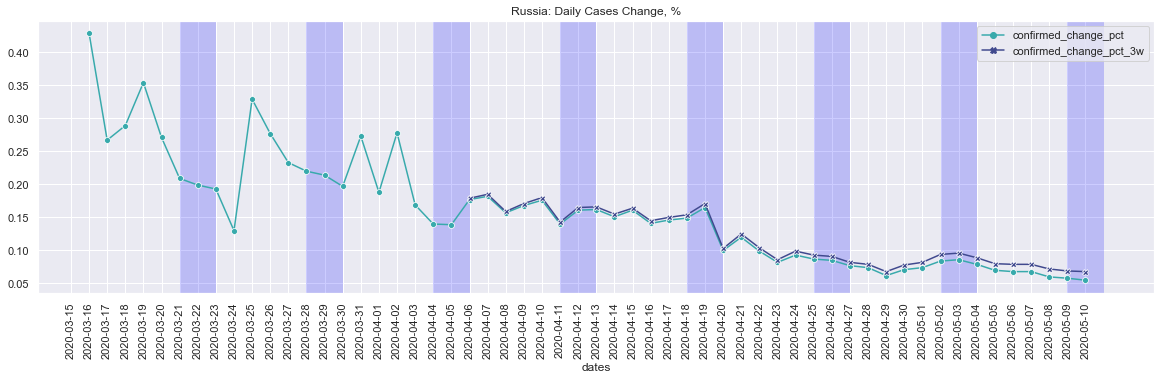

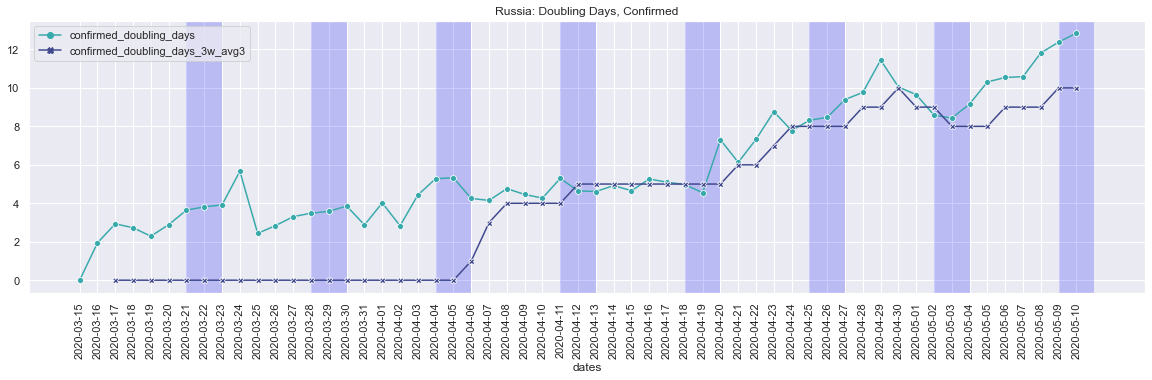

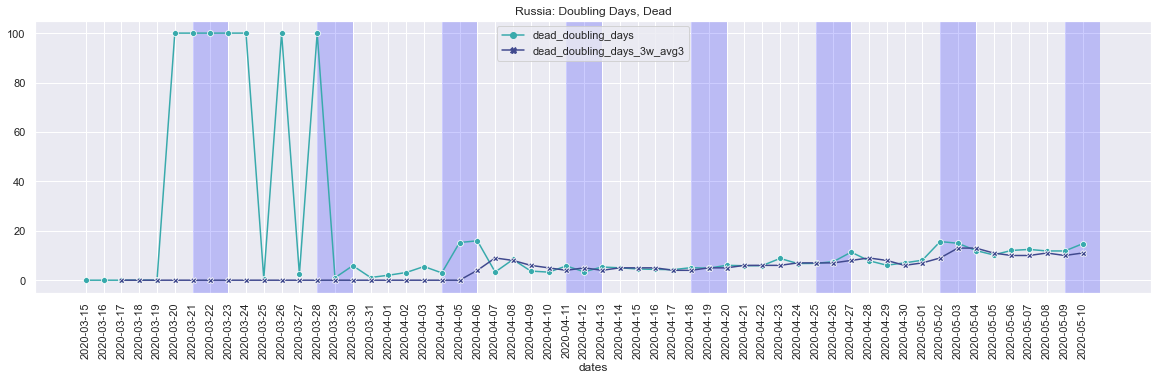

In [35]:
print_charts_country(df_russia, 'Russia', date_cutoff='2020-03-15')

In [ ]:
# df = add_forecast_prophet(df_russia, 'confirmed_peak', 30)
# plot_peak(df, columns=['confirmed_peak', 'confirmed_peak_pred'], title = 'Russia: Peak', date_cutoff='2020-04-15')

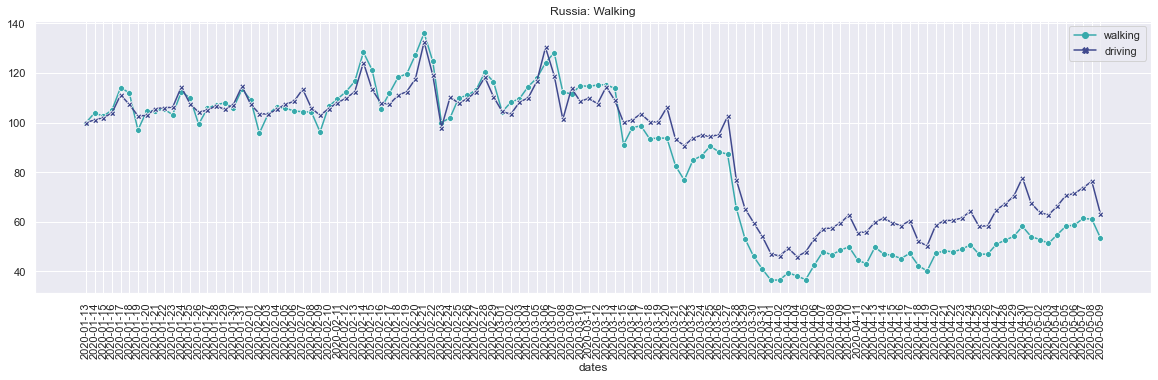

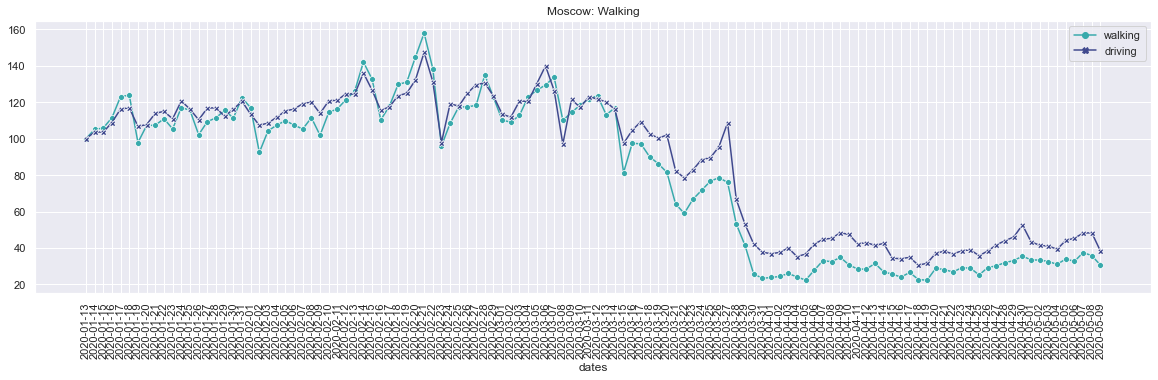

In [37]:
plot_line(apple_filter_region(dfapple, "Russia"), columns=['walking', 'driving'], title='Russia: Walking')
plot_line(apple_filter_region(dfapple, "Moscow"), columns=['walking', 'driving'], title='Moscow: Walking')

# Sweden

In [50]:
# df_sweden = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Sweden', country_code='SWE', date_cutoff='2020-03-15')
# print_charts_country(df_sweden, 'Sweden', date_cutoff='2020-03-15')

In [39]:
# df = add_forecast_prophet(df_sweden, 'confirmed_peak', 30)
# plot_peak(df, columns=['confirmed_peak', 'confirmed_peak_pred'], title = 'Sweden: Peak', date_cutoff='2020-04-15')

# UK

In [40]:
# df_uk = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'United Kingdom', country_code='GBR', date_cutoff='2020-03-15')
# print_charts_country(df_uk, 'UK', date_cutoff='2020-03-15')

# US

In [41]:
# df_us = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'US', country_code='USA', date_cutoff='2020-03-15')
# print_charts_country(df_us, 'US', date_cutoff='2020-03-15')

# Germany

In [42]:
# df_germany = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Germany', country_code='DEU', date_cutoff='2020-03-15')
# print_charts_country(df_germany, 'Germany', date_cutoff='2020-03-15')

In [43]:
# df = add_forecast_prophet(df_germany, 'confirmed_peak', 15)
# plot_peak(df, columns=['confirmed_peak', 'confirmed_peak_pred'], title = 'Germany: Peak', date_cutoff='2020-04-15')

# France

In [44]:
# df_france = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'France', country_code='FRA', date_cutoff='2020-03-15')
# print_charts_country(df_france, 'France', date_cutoff='2020-03-15')

In [45]:
# df = add_forecast_prophet(df_france, 'confirmed_peak', 15)
# plot_peak(df, columns=['confirmed_peak', 'confirmed_peak_pred'], title = 'France: Peak', date_cutoff='2020-04-15')

# Spain

In [46]:
# df_spain = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Spain', country_code='ESP',
#                                date_cutoff='2020-03-15')
# print_charts_country(df_spain, 'Spain', date_cutoff='2020-03-15')


In [47]:
# df = add_forecast_prophet(df_spain, 'confirmed_peak', 15)
# plot_peak(df, columns=['confirmed_peak', 'confirmed_peak_pred'], title = 'Spain: Peak', date_cutoff='2020-04-15')

# Italy

In [48]:
# df_italy = prepare_df_country(dfcovid_conf_t, dfcovid_dead_t, 'Italy', country_code='ITA',
#                                date_cutoff='2020-03-15')
# print_charts_country(df_italy, 'Italy', date_cutoff='2020-03-15')


In [51]:
# df = add_forecast_prophet(df_italy, 'confirmed_peak', 20)
# plot_peak(df, columns=['confirmed_peak', 'confirmed_peak_pred'], title = 'Italy: Peak', date_cutoff='2020-04-15')

# Compare Infections

In [52]:
# countries = {
#              "Russia": df_russia,
#              "UK": df_uk,
#              "US": df_us,
#              "Sweden": df_sweden,
#              "Germany": df_germany,
#              "France": df_france,
#              "Spain": df_spain,
#              "Italy": df_italy,
#              }

In [53]:
# confirmed_per_100k = join_series_day_since(countries, 'confirmed_per_100k')
# confirmed_change_per_100k = join_series_day_since(countries, 'confirmed_change_per_100k')

# plot_lines_plotly(confirmed_per_100k, "Confirmed Cases per 100k of Population", show_doubling=True, doubling_days=7)
# plot_lines_plotly(confirmed_change_per_100k.rolling(7, win_type='triang').mean().round(2), "Daily Cases per 100k of population, rolling mean over 7 days", showlegend=True, show_doubling=True, doubling_days=7)


# plot_line(confirmed_per_100k.rolling(2, win_type='triang').mean().dropna(), figsize=(10, 15),
#           columns=list(countries.keys()), title='Confirmed Cases per 100k of Population', log_y=True)
# plot_line(confirmed_change_per_100k.rolling(7, win_type='triang').mean().dropna(), figsize=(20, 7)
#           , columns=list(countries.keys()), title='Daily Cases per 100k of Population')

In [54]:
# plot_lines_plotly(join_series_date(countries, 'confirmed_per_100k'), "Confirmed Cases per 100k of Population", show_doubling=False, doubling_days=7)
# plot_lines_plotly(join_series_date(countries, 'confirmed_change_per_100k').rolling(7, win_type='triang').mean().round(2), "Daily Cases per 100k of population, rolling mean over 7 days", showlegend=True, show_doubling=False, doubling_days=7)

---

In [55]:
# plot_lines_plotly(join_series_date(lands_calculated, 'confirmed_per_100k'), "Confirmed Cases per 100k of Population", show_doubling=False, doubling_days=7)
# plot_lines_plotly(join_series_date(lands_calculated, 'confirmed_change_per_100k').rolling(7, win_type='triang').mean().round(2), "Daily Cases per 100k of population, rolling mean over 7 days", showlegend=True, show_doubling=False, doubling_days=7)

In [56]:
# cities = {
#              'Hamburg':df_hamburg,
#              "Berlin": df_berlin,
#              "Bavaria": df_bavaria,
#              "Germany": df_germany,
#              "Russia": df_russia,

#              }

# confirmed_per_100k = join_series_day_since(cities, 'confirmed_per_100k')
# confirmed_change_per_100k = join_series_day_since(cities, 'confirmed_change_per_100k') 

# plot_lines_plotly(confirmed_per_100k, "Confirmed Cases per 100k of Population", show_doubling=True, doubling_days=7)
# plot_lines_plotly(confirmed_change_per_100k.rolling(7, win_type='triang').mean().round(2), "Daily Cases per 100k of population, rolling mean over 7 days", showlegend=True, show_doubling=True, doubling_days=7)



# plot_line(confirmed_per_100k.rolling(3, win_type='triang').mean(), figsize=(10, 15),
#           columns=list(cities.keys()), title='Confirmed Cases per 100k of Population', log_y=True)
# plot_line(confirmed_change_per_100k.rolling(3, win_type='triang').mean(), figsize=(20, 7)
#           , columns=list(cities.keys()), title='Daily Cases per 100k of Population')

---